In [3]:
import os

import jax.numpy as jnp
import jax.random as jr
import jaxtyping
import optax
import pandas as pd
import seaborn as sns
import seaborn.objects as so

sns.set_style("whitegrid")

with jaxtyping.install_import_hook(["cnpe", "cnpe_validation"], "beartype.beartype"):
    from cnpe import losses
    from cnpe.train import train

    from cnpe_validation.tasks.multimodal_gaussian import (
        MultimodelGaussianWellSpecifiedGuideTask,
    )
    from cnpe_validation.utils import get_abspath_project_root

os.chdir(get_abspath_project_root())

In [4]:
key, subkey = jr.split(jr.PRNGKey(3))

vi_steps= 20000
maximum_likelihood_steps = 10000
contrastive_steps = 10000
num_contrastive = 20

task = MultimodelGaussianWellSpecifiedGuideTask(subkey)

key, subkey = jr.split(key)
true_latents, obs = task.get_latents_and_observed_and_validate(subkey)

posteriors = {}
optimizer = optax.adam(optax.linear_schedule(1e-2, 1e-3, maximum_likelihood_steps))

# Train using VI
method_name = "ELBO"
loss = losses.NegativeEvidenceLowerBound(task.model.reparam(set_val=True), obs=obs)

key, subkey = jr.split(key)
posteriors[method_name], _ = train(
    subkey,
    guide=task.guide,
    loss_fn=loss,
    steps=vi_steps,
    optimizer=optimizer,
)

# Train using maximum likelihood
loss = losses.AmortizedMaximumLikelihood(task.model.reparam(set_val=True))

ml_posterior, _ = train(
    subkey,
    guide=task.guide,
    loss_fn=loss,
    steps=maximum_likelihood_steps,
    optimizer=optimizer,
)

optimizer = optax.apply_if_finite(
        optax.adam(optax.linear_schedule(1e-2, 1e-3, maximum_likelihood_steps)),
    max_consecutive_errors=100,
)

# # Fine tune with contrastive loss
method_name = "NPE-PP"
loss = losses.ContrastiveLoss(
    model=task.model.reparam(),
    obs=obs,
    n_contrastive=num_contrastive,
    stop_grad_for_contrastive_sampling=False,
)

key, subkey = jr.split(key)

posteriors[method_name], _ = train(
    subkey,
    guide=ml_posterior,
    loss_fn=loss,
    steps=contrastive_steps,
    optimizer=optimizer,
)

distributions = {
    k: posterior.mu.to_dist(obs["x"]) for k, posterior in posteriors.items()
} | {"True Posterior": task.model.get_true_posterior(obs)}

mu = jnp.linspace(-1.1, 1.1, 500)

densities = {
    k: jnp.exp(dist.log_prob(mu)) for k, dist in distributions.items()
}
df = pd.DataFrame(
    densities | {"mu": mu},
    ).melt(id_vars="mu", value_name="Density", var_name="Distribution")
p = so.Plot(
    df,
    x="mu",
    y="Density",
    color="Distribution",
).add(so.Area()).label(x=r"$\mu$")
p.save(f"plots/mass_covering.pdf")
p.show()


  1%|          | 139/20000 [00:03<08:43, 37.93it/s, loss=14.5]   


KeyboardInterrupt: 

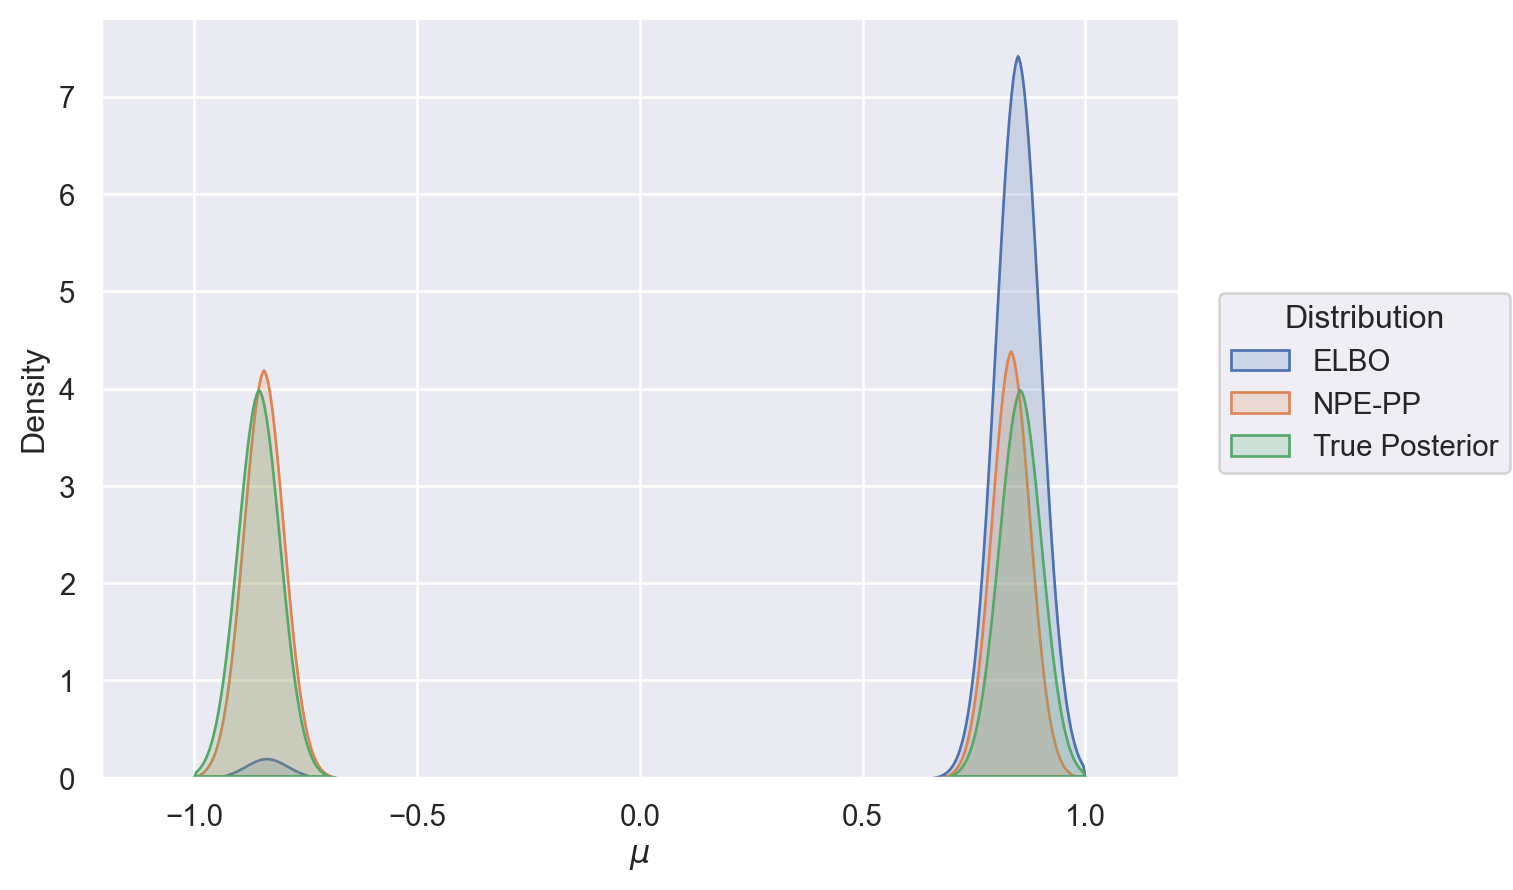